<a href="https://colab.research.google.com/github/JavadMokhtari/dapa-group/blob/main/Train_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

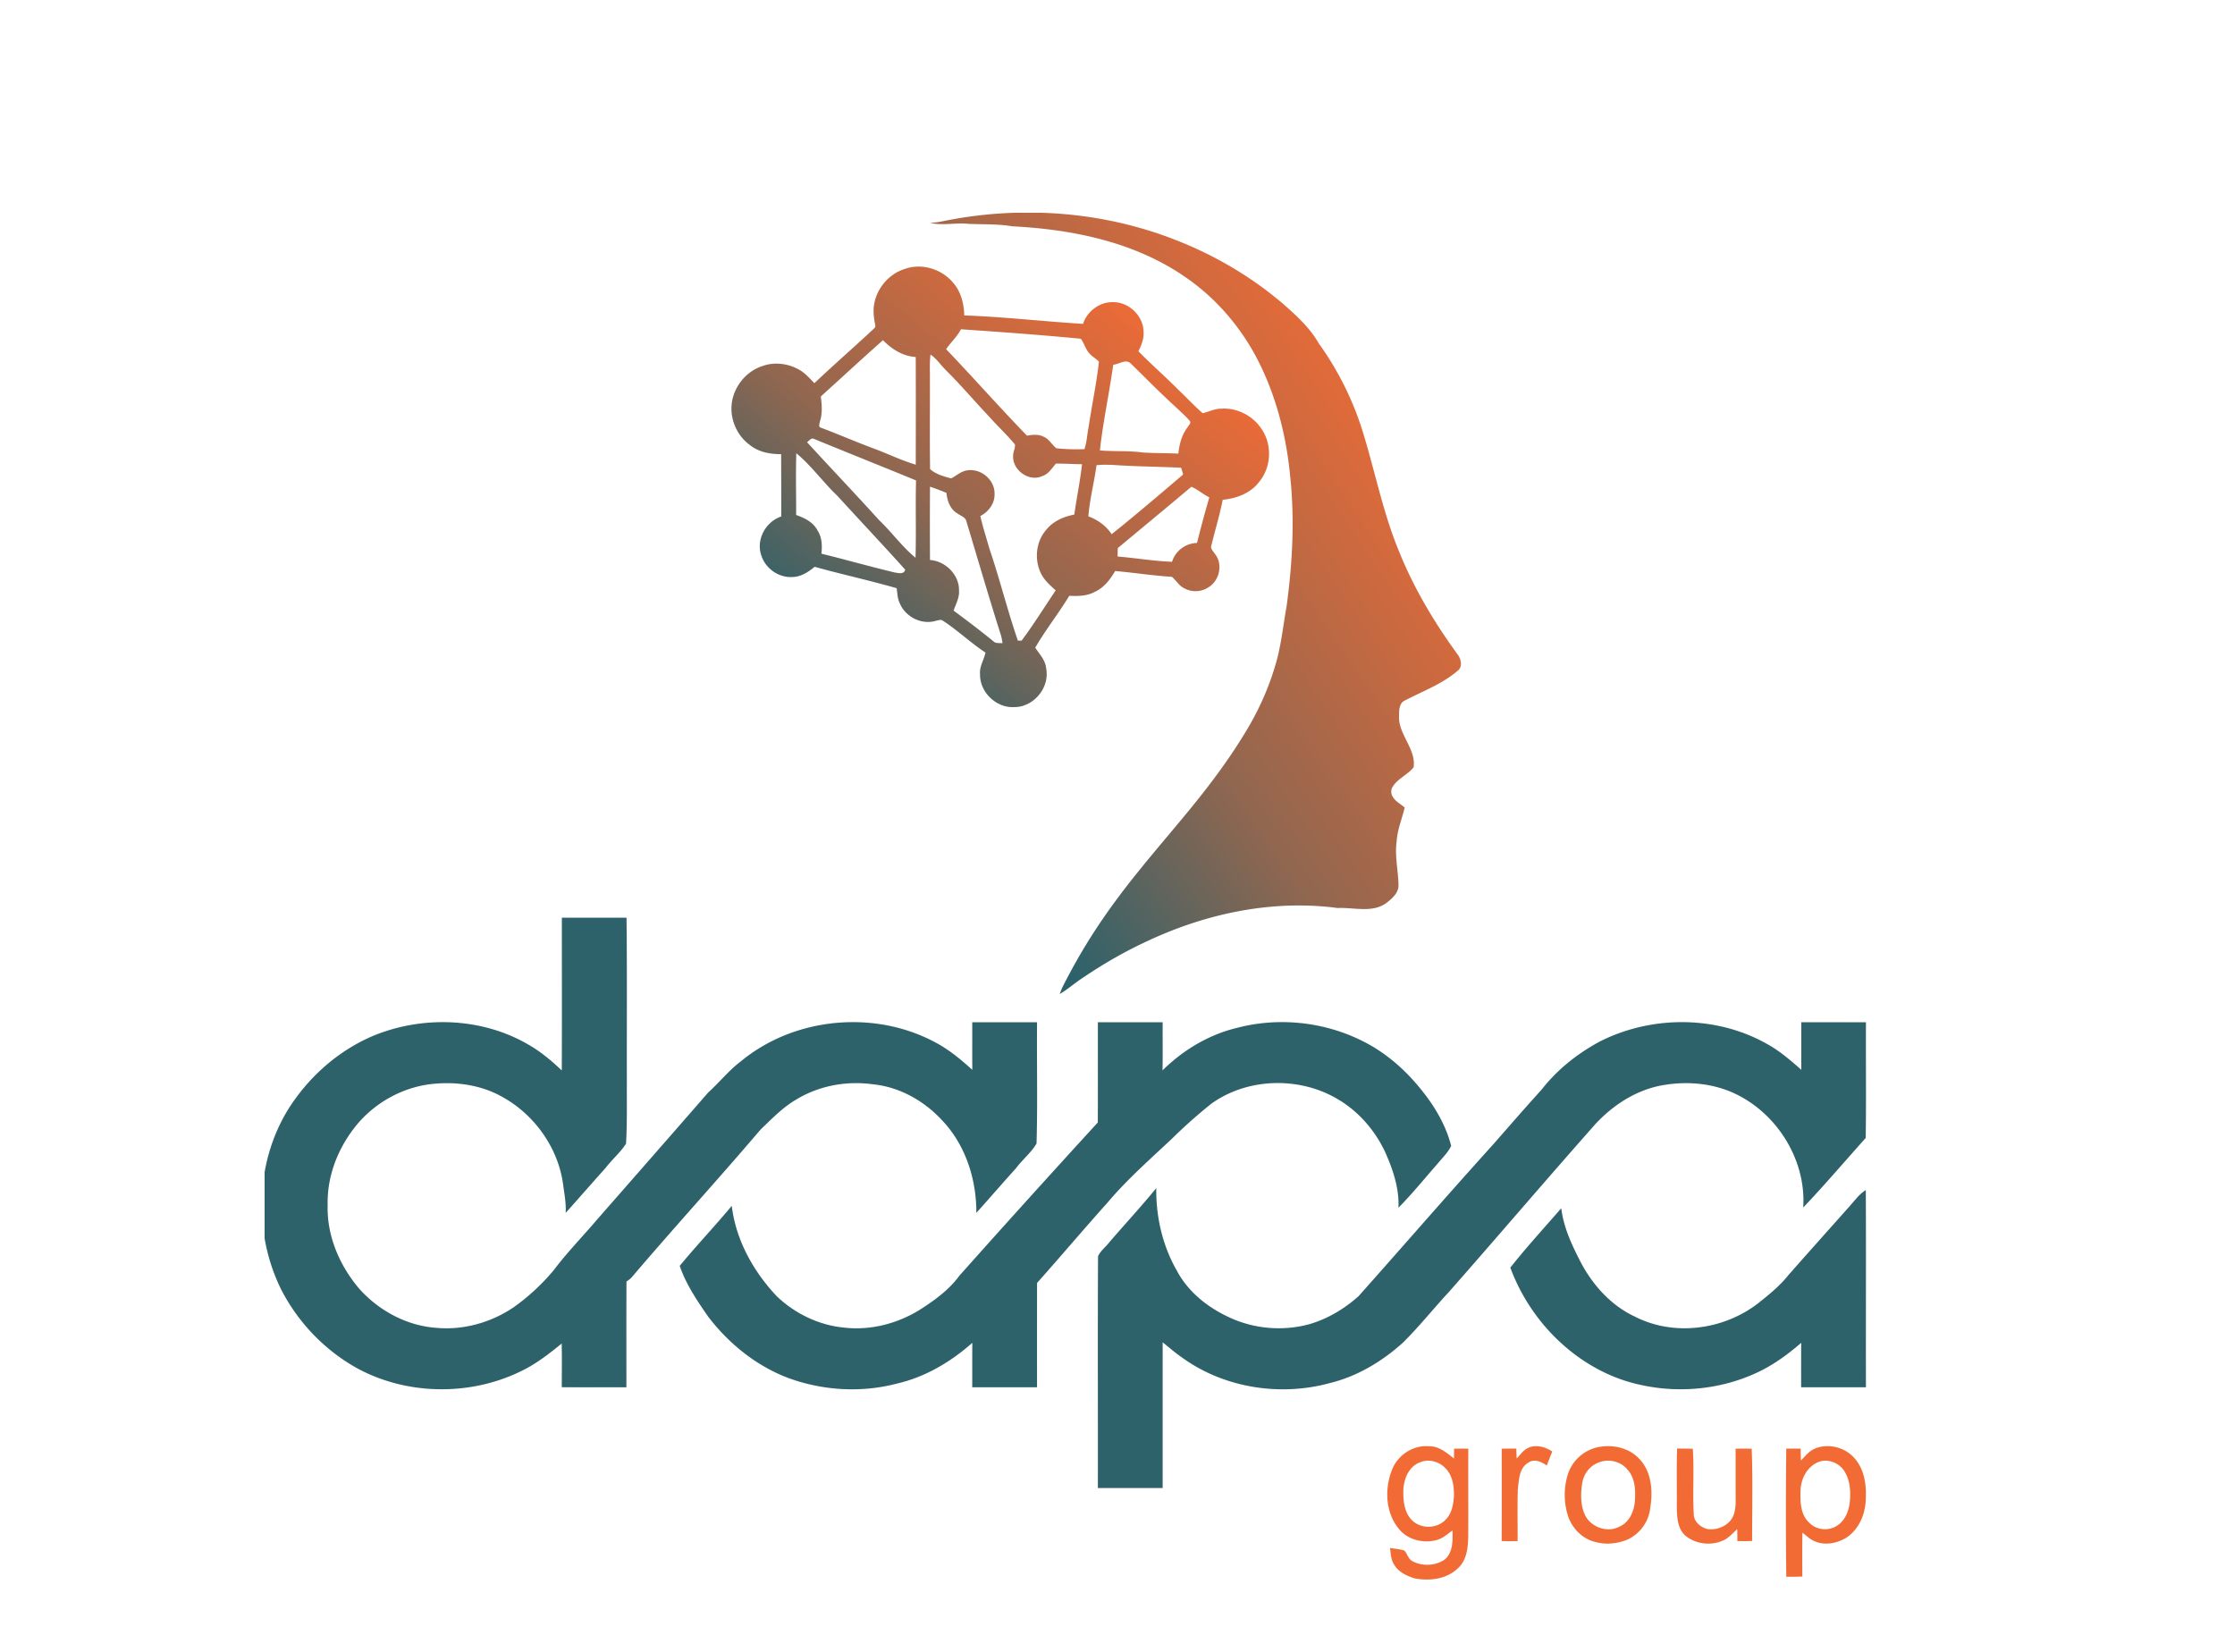
# <h1><center>Train Generative Adversarial Network (GAN)</center></h1>

In [ ]:
# Import Libraries
import tensorflow as tf
from tensorflow import keras
import pathlib
import matplotlib.pyplot as plt
import PIL.Image
from IPython import display
import time

In [ ]:
from tensorflow.python import training
model = keras.Sequential([keras.Input(shape=(3, 3)),
                          keras.layers.Dense(10,
                                    activation='softmax')])

model(tf.random.normal([3, 3]), training=False)

<tf.Tensor: shape=(3, 10), dtype=float32, numpy=
array([[0.2031792 , 0.098668  , 0.05538487, 0.19513264, 0.03784468,
        0.06408797, 0.07036418, 0.09228884, 0.03154806, 0.15150154],
       [0.07598197, 0.07795453, 0.31210375, 0.04883492, 0.07252016,
        0.0370126 , 0.08281294, 0.08856098, 0.02299151, 0.1812267 ],
       [0.09040646, 0.0661472 , 0.00814707, 0.2654095 , 0.01310046,
        0.09871815, 0.01119449, 0.14375496, 0.01188215, 0.29123947]],
      dtype=float32)>

## Preparation Dataset

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)

# Set the path of data
data_dir = pathlib.Path(archive).with_suffix('')
print(data_dir)

/root/.keras/datasets/flower_photos


In [ ]:
# Number of total images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


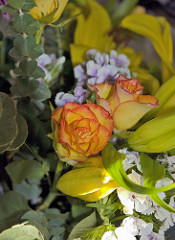

In [ ]:
# Show an image of rose class
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [ ]:
# Define the batch size
BATCH_SIZE = 32

# Define the image size
IMG_HEIGHT = 64
IMG_WIDTH = 64

In [ ]:
# Create the train dataset from the image directory
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
# Create the validation dataset from the image directory
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
# Print all names of classes
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
# Define a layer to randomly flip images horizontally
flip_layer = keras.layers.RandomFlip('horizontal')

# Define a layer to standardization of input images
normalization_layer = keras.layers.Rescaling(1./255)

# Apply random horizontal flipping layer to train dataset
train_ds = train_ds.map(lambda x, y: (flip_layer(x), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Apply random horizontal flipping layer to validation dataset
val_ds = val_ds.map(lambda x, y: (flip_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

## Generative Adversarial Network (GAN)
# 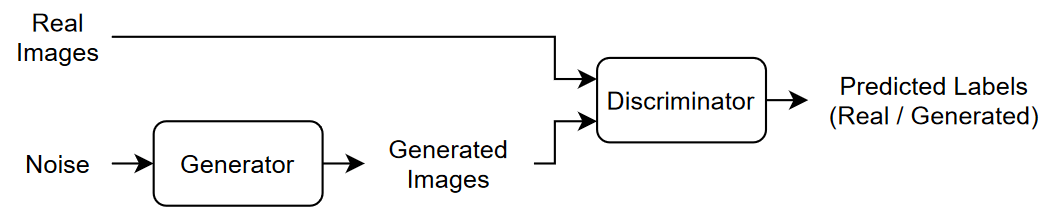
[Image from MathWorks](https://www.mathworks.com/help/examples/nnet/win64/TrainGenerativeAdversarialNetworkGANExample_03.png)

In [ ]:
# Set some parameters of model
KERNEL_SIZE = 5
NUM_FILETERS = 64
PROJECTION_SHAPE = [4, 4, 512]

# Define the Generator network
generator = keras.Sequential([
    keras.Input(shape=(100,)),
    keras.layers.Dense(4*4*512, use_bias=False),
    keras.layers.Reshape(PROJECTION_SHAPE),
    keras.layers.Conv2DTranspose(filters = 4 * NUM_FILETERS,
                                    kernel_size = KERNEL_SIZE,
                                    use_bias = False),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv2DTranspose(filters = 2 * NUM_FILETERS,
                                 kernel_size = KERNEL_SIZE,
                                 strides = (2, 2),
                                 padding = 'same',
                                 use_bias = False),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv2DTranspose(filters = NUM_FILETERS,
                                 kernel_size = KERNEL_SIZE,
                                 strides = (2, 2),
                                 padding = 'same',
                                 use_bias = False),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv2DTranspose(filters = 3,
                                 kernel_size = KERNEL_SIZE, 
                                 strides = (2, 2),
                                 padding = 'same',
                                 use_bias = False,
                                 activation = 'tanh')])

(1, 64, 64, 3)


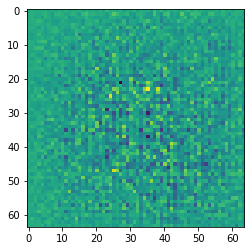

In [ ]:
# Create a noisy signal
noise = tf.random.normal([1, 100])

# Generate image by designed model
generated_image = generator(noise, training=False)
print(generated_image.shape)
# Shwo generated image by the model 
plt.imshow(generated_image[0, :, :, 0])

In [ ]:
# Set some parameters of model
DROPOUT_PROB = 0.5
LEAKY_ALPHA = 0.2
GENERATED_OUTPUT_SHAPE = [64, 64, 3]

# Define the Discriminator network
discriminator = keras.Sequential([
    keras.Input(shape=GENERATED_OUTPUT_SHAPE),
    keras.layers.Dropout(DROPOUT_PROB),
    keras.layers.Conv2D(filters = NUM_FILETERS,
                        kernel_size = KERNEL_SIZE,
                        strides = (2, 2),
                        padding = 'same'),
    keras.layers.LeakyReLU(alpha = LEAKY_ALPHA),
    keras.layers.Conv2D(filters = 2 * NUM_FILETERS,
                        kernel_size = KERNEL_SIZE,
                        strides = (2, 2),
                        padding = 'same'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha = LEAKY_ALPHA),
    keras.layers.Conv2D(filters = 4 * NUM_FILETERS,
                        kernel_size = KERNEL_SIZE,
                        strides = (2, 2),
                        padding = 'same'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha = LEAKY_ALPHA),
    keras.layers.Conv2D(filters = 8 * NUM_FILETERS,
                        kernel_size = KERNEL_SIZE,
                        strides = (2, 2),
                        padding = 'same'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha = LEAKY_ALPHA),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid'),
    ])

In [ ]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.5000023]], shape=(1, 1), dtype=float32)


In [ ]:
# Define Generator loss function
def generator_loss(y_gen):
    return - tf.math.reduce_mean(tf.math.log(y_gen))

# Define Discriminator loss function
def discriminator_loss(y_real, y_gen):
    return - tf.math.reduce_mean(tf.math.log(y_real)) - \
    tf.math.reduce_mean(tf.math.log(tf.ones_like(y_gen) - y_gen))

# Define Generator score to measure achieve its goal
def gen_score(y_gen):
    return tf.math.reduce_mean(y_gen)

# Define Discriminator score to measure achieve its goal
def disc_score(y_real, y_gen):
    return (tf.math.reduce_mean(y_real) + tf.math.reduce_mean(1 - y_gen)) / 2.0

In [ ]:
# Specify training options
LR = 2e-4
EPOCHS = 500
NOISE_DIM = 100
NUM_INIT_EXAMPLE = 16

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(LR)
discriminator_optimizer = tf.keras.optimizers.Adam(LR)

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch, label_batch in dataset:
      train_step(image_batch)

    print(f'Time for epoch {epoch + 1} is {time.time()-start:.3f} sec')

In [ ]:
train(train_ds, EPOCHS)

Time for epoch 1 is 11.449971914291382 sec
Time for epoch 2 is 5.779937505722046 sec
Time for epoch 3 is 5.816272020339966 sec
Time for epoch 4 is 6.614924192428589 sec
Time for epoch 5 is 5.928441047668457 sec
Time for epoch 6 is 6.174944639205933 sec
Time for epoch 7 is 6.013629198074341 sec
Time for epoch 8 is 10.268917083740234 sec
Time for epoch 9 is 7.810862064361572 sec
Time for epoch 10 is 5.891815185546875 sec
Time for epoch 11 is 6.301641941070557 sec
Time for epoch 12 is 5.903256416320801 sec
Time for epoch 13 is 6.276695251464844 sec
Time for epoch 14 is 6.401031732559204 sec
Time for epoch 15 is 6.640500545501709 sec
Time for epoch 16 is 5.867857456207275 sec
Time for epoch 17 is 6.258039712905884 sec
Time for epoch 18 is 5.861279249191284 sec
Time for epoch 19 is 6.503033399581909 sec
Time for epoch 20 is 6.208764553070068 sec
Time for epoch 21 is 6.278839349746704 sec
Time for epoch 22 is 10.278723239898682 sec
Time for epoch 23 is 10.249966859817505 sec
Time for epoch 2